In [1]:
import numpy as np
from matplotlib import pyplot as plt
from photometry import *
from paths import *

setup_logging()

region = 'N'
path_data = path_data(region)
path_randoms = path_randoms(region)
path_mctool = path_mctool(region)

In [2]:
#First some functions to get the footprint and the weights-corrected density

def get_footprint(randoms,nside=None,nest=None):
    map = Catalogue.load(path_hp)
    if nside is None: nside = map.header['HPXNSIDE']
    if nest is None: nest = map.header['HPXNEST']
    toret = HealpixDensity(nside=nside,nest=nest,ref=randoms)
    toret.set_randoms(randoms)
    mask = np.all([map['PSFDEPTH_{}'.format(b)]>0. for b in randoms.bands],axis=0)
    mask = utils.ud_hpmap(mask,nside_out=toret.nside,nest_out=toret.nest,nest_in=map.header['HPXNEST'])[toret.brickid]
    return toret[mask]

def get_weighted_density(data,randoms,weighted=False,divide=True,return_weights=False,path_mctool=None):
    props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] +  ['PSFSIZE_{}'.format(b) for b in data.bands]
    weights = None
    brickid = get_footprint(randoms).brickid
    if weighted == 'lin' or not weighted:
        map = Catalogue.load(path_hp)
        dens = HealpixDensity(map=map,brickid=brickid)
        dens.set_randoms(randoms=randoms)
        dens.set_properties()
        dens.set_data(data=data)
    if weighted == 'lin':
        m = LinearModel(density=dens)
        m.fit(props=props)
        weights = m.predict()
    if weighted == 'mc':
        map = Catalogue.load(path_mctool)
        dens = HealpixDensity(map=map,brickid=brickid)
        dens.set_randoms(randoms=randoms)
        dens.set_properties()
        dens.set_data(data=data)
        weights = dens.properties['MCEFF']
    if weighted == 'mclin':
        map = Catalogue.load(path_mctool)
        dens = HealpixDensity(map=map,brickid=brickid)
        dens.set_randoms(randoms=randoms)
        dens.set_properties()
        dens.set_data(data=data)
        m = LinearModel(density=dens/dens.properties['MCEFF'])
        m.fit(props=props)
        weights = m.predict()*dens.properties['MCEFF']
    if weighted and divide:
        dens /= weights
    if return_weights: return dens,weights
    return dens

[ 000000.03 ]: 12-09 05:27  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/targets_ELG_dr9m/data_NGC.fits.
[ 000013.85 ]: 12-09 05:27  TargetSelection INFO     Selecting 11666658/11666658 targets.
[ 000028.32 ]: 12-09 05:27  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/targets_ELG_dr9m/randoms_NGC.fits.
[ 000037.26 ]: 12-09 05:27  TargetSelection INFO     Selecting 4760082/4760082 targets.
[ 000047.03 ]: 12-09 05:28  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/catalogs/dr9m/0.42.0/pixweight/main/resolve/dark/pixweight-dark.fits.
[ 000047.53 ]: 12-09 05:28  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000047.54 ]: 12-09 05:28  HealpixDensity  INFO     Found 97947 bricks with randoms.
[ 000047.56 ]: 12-09 05:28  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/catalogs/dr9m/0.42.0/pixweight/main/resolve/dark/pixweight-dark.fits.
[ 000047.61 ]: 12-09 05:28  HealpixDensi

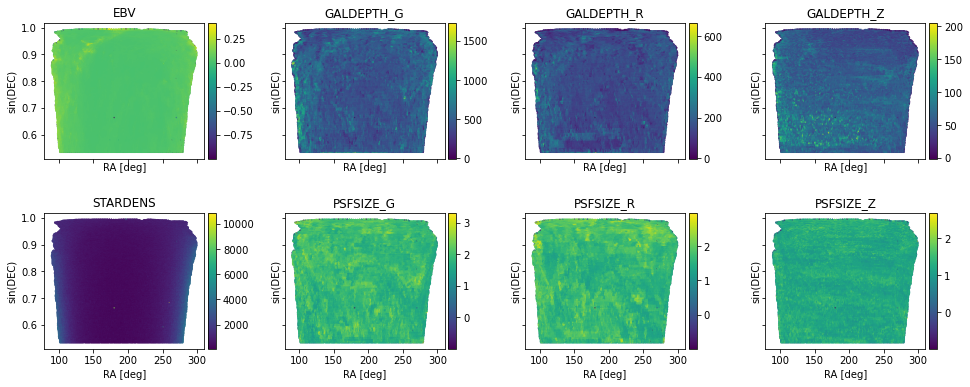

[ 000066.97 ]: 12-09 05:28  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0187.
[ 000066.99 ]: 12-09 05:28  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0187.
[ 000066.99 ]: 12-09 05:28  Properties      INFO     Calculating EBV statistics.
[ 000067.02 ]: 12-09 05:28  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0171.
[ 000067.06 ]: 12-09 05:28  HealpixDensity  INFO     Fraction of randoms not included in GALDEPTH_G plot: 0.0169.
[ 000067.08 ]: 12-09 05:28  HealpixDensity  INFO     Fraction of randoms not included in GALDEPTH_G plot: 0.0169.
[ 000067.08 ]: 12-09 05:28  Properties      INFO     Calculating GALDEPTH_G statistics.
[ 000067.13 ]: 12-09 05:28  HealpixDensity  INFO     Fraction of randoms not included in GALDEPTH_G plot: 0.0154.
[ 000067.16 ]: 12-09 05:28  HealpixDensity  INFO     Fraction of randoms not included in GALDEPTH_R plot: 0.0167.
[ 000067.18 ]: 12-09 05:28  HealpixDensity  INFO     F

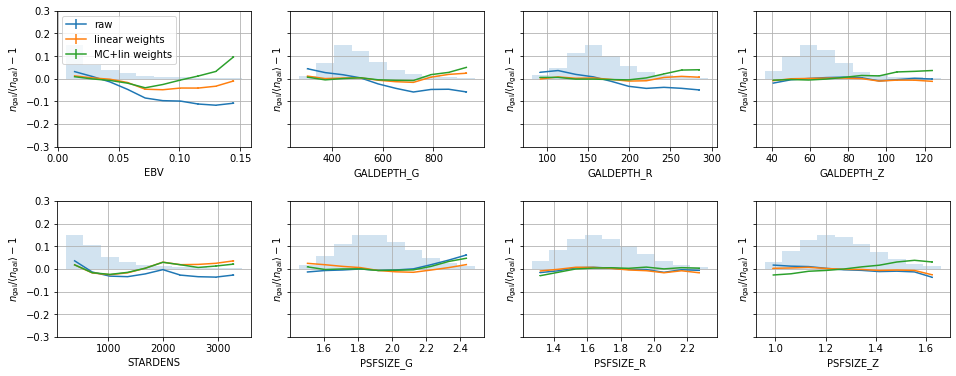

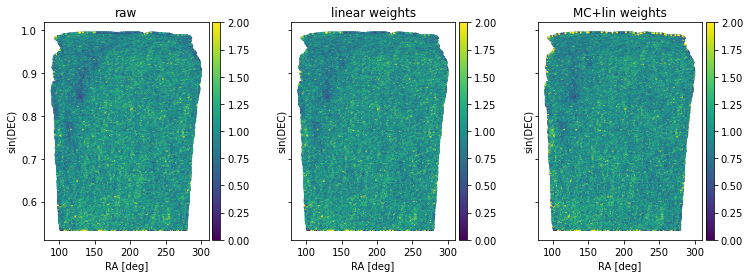

In [3]:
toplot = ['lin','mclin']

data = TargetSelection.load_objects(path_data,region=region)
randoms = TargetSelection.load_objects(path_randoms,region=region)

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] +  ['PSFSIZE_{}'.format(b) for b in data.bands]

dens = get_weighted_density(data,randoms,weighted=False)
others = []
labels = None

if 'lin' in toplot:
    others += [get_weighted_density(data,randoms,weighted='lin')]
    labels = ['raw','linear weights']

if 'mc' in toplot:
    others += [get_weighted_density(data,randoms,weighted='mc',path_mctool=path_mctool)]
    if labels is not None:
        labels += ['MC weights']
    else:
        labels = ['raw','MC weights']

if 'mclin' in toplot:
    others += [get_weighted_density(data,randoms,weighted='mclin',path_mctool=path_mctool)]
if labels is not None:
    labels += ['MC+lin weights']
else:
    labels = ['raw','MC+lin weights']

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=True,sharey=True,figsize=(16,6))
fig.subplots_adjust(hspace=0.4,wspace=0.4)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_property_map(ax=lax[iax],prop=prop,s=0.1,title=prop,clabel=False)
plt.show()

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(16,6))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},xedges={'quantiles':[0.01,0.99]})
plt.show()

fig,lax = plt.subplots(ncols=len([dens] + others),nrows=1,sharex=True,sharey=True,figsize=(12,4))
fig.subplots_adjust(hspace=0.4,wspace=0.4)
lax = lax.flatten()
for iax,dens in enumerate([dens] + others):
    dens.plot_density_map(ax=lax[iax],s=1,title=labels[iax],vmin=0,vmax=2)
plt.show()